#**Import**

In [ ]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imread
import numpy as np
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
import pickle
import seaborn as sns
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
import torchvision
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
import os
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
Categories=['trash','recycle','organics', 'hazardous']

#**Load Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir="/content/drive/My Drive/APS360data/train"
val_dir="/content/drive/My Drive/APS360data/val"
test_dir="/content/drive/My Drive/APS360data/test"

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

torch.manual_seed(1)
# Define transformations and normalization for your images:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for the resnet model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization for ImageNet
])

# Load datasets:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Set up data loaders:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  #Shuffle is to ensure the model isn’t adapting its learning to any kind of spurious pattern.
validation_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#**Model**

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = input + shortcut
        return nn.ReLU()(input)

In [ ]:
class ResNet18(nn.Module):
    def __init__(self, in_channels, resblock, num_classes = 4):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer1 = nn.Sequential(
            resblock(64, 64, downsample=False),
            resblock(64, 64, downsample=False)
        )

        self.layer2 = nn.Sequential(
            resblock(64, 128, downsample=True),
            resblock(128, 128, downsample=False)
        )

        self.layer3 = nn.Sequential(
            resblock(128, 256, downsample=True),
            resblock(256, 256, downsample=False)
        )


        self.layer4 = nn.Sequential(
            resblock(256, 512, downsample=True),
            resblock(512, 512, downsample=False)
        )

        self.gap = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = torch.nn.Linear(512, 4)

    def forward(self, input):
        input = self.layer0(input)
        input = self.layer1(input)
        input = self.layer2(input)
        input = self.layer3(input)
        input = self.layer4(input)
        input = self.gap(input)
        input = torch.flatten(input, start_dim=1)
        input = self.fc(input)

        return input


In [ ]:
from torchsummary import summary
resnet18 = ResNet18(3, ResBlock, num_classes = 4)
resnet18.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
summary(resnet18, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
         MaxPool2d-2           [-1, 64, 56, 56]               0
       BatchNorm2d-3           [-1, 64, 56, 56]             128
              ReLU-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,928
       BatchNorm2d-6           [-1, 64, 56, 56]             128
            Conv2d-7           [-1, 64, 56, 56]          36,928
       BatchNorm2d-8           [-1, 64, 56, 56]             128
          ResBlock-9           [-1, 64, 56, 56]               0
           Conv2d-10           [-1, 64, 56, 56]          36,928
      BatchNorm2d-11           [-1, 64, 56, 56]             128
           Conv2d-12           [-1, 64, 56, 56]          36,928
      BatchNorm2d-13           [-1, 64, 56, 56]             128
         ResBlock-14           [-1, 64,

#**Train the model**

In [ ]:
resnet18_pretrained = models.resnet.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 60.3MB/s]


In [ ]:
def train_net(model, train_loader, val_loader, batch_size=32,
              lr=0.001, num_epochs=15):
    criterion = nn.CrossEntropyLoss()
    # For multi-class classification
    optimizer = optim.Adam(resnet18.parameters(), lr=0.001)  # Use Adam optimizer with a learning rate of 0.01

    n = 0
    iters, losses, train_acc_list,val_acc_list = [],[],[],[]
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        train_preds = []
        train_targets = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu")), labels.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_preds.extend(predicted.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = accuracy_score(train_targets, train_preds)
        train_acc_list.append(epoch_acc)
        epoch_f1 = f1_score(train_targets, train_preds, average='weighted')


        model.eval()  # Set model to evaluate mode
        val_running_loss = 0.0
        val_preds = []
        val_targets = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu")), labels.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_preds.extend(predicted.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = accuracy_score(val_targets, val_preds)
        val_acc_list.append(val_acc)
        val_f1 = f1_score(val_targets, val_preds, average='weighted')

        n += 1
        iters.append(n)
        losses.append(float(val_loss)/batch_size)

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Training Accuracy: {epoch_acc:.4f}, F1-Score: {epoch_f1:.4f}, Loss: {epoch_loss:.4f}')
        print(f'Validation Accuracy: {val_acc:.4f}, F1-Score: {val_f1:.4f}, Loss: {val_loss:.4f}, ')
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Accuracy Curve")
    plt.plot(iters, train_acc_list, label="Training")
    plt.plot(iters, val_acc_list, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [ ]:
train_net(resnet18,train_loader, validation_loader,
          batch_size = 32, lr = 0.001, num_epochs = 15)

Epoch 1/15
Training Accuracy: 0.6050, F1-Score: 0.6034, Loss: 1.1290
Validation Accuracy: 0.4550, F1-Score: 0.4086, Loss: 10.3019, 
Epoch 2/15
Training Accuracy: 0.6983, F1-Score: 0.6949, Loss: 0.8232
Validation Accuracy: 0.7150, F1-Score: 0.6960, Loss: 0.8292, 
Epoch 3/15
Training Accuracy: 0.7167, F1-Score: 0.7087, Loss: 0.7692
Validation Accuracy: 0.6250, F1-Score: 0.6128, Loss: 0.8808, 
Epoch 4/15
Training Accuracy: 0.7017, F1-Score: 0.6947, Loss: 0.7547
Validation Accuracy: 0.6650, F1-Score: 0.6642, Loss: 0.7715, 
Epoch 5/15
Training Accuracy: 0.7367, F1-Score: 0.7336, Loss: 0.6711
Validation Accuracy: 0.6800, F1-Score: 0.6807, Loss: 0.8254, 
Epoch 6/15
Training Accuracy: 0.7383, F1-Score: 0.7363, Loss: 0.6930
Validation Accuracy: 0.6450, F1-Score: 0.6507, Loss: 0.8455, 
Epoch 7/15
Training Accuracy: 0.7300, F1-Score: 0.7302, Loss: 0.6561
Validation Accuracy: 0.6950, F1-Score: 0.6869, Loss: 0.7913, 
Epoch 8/15
Training Accuracy: 0.7733, F1-Score: 0.7713, Loss: 0.6325
Validation Ac

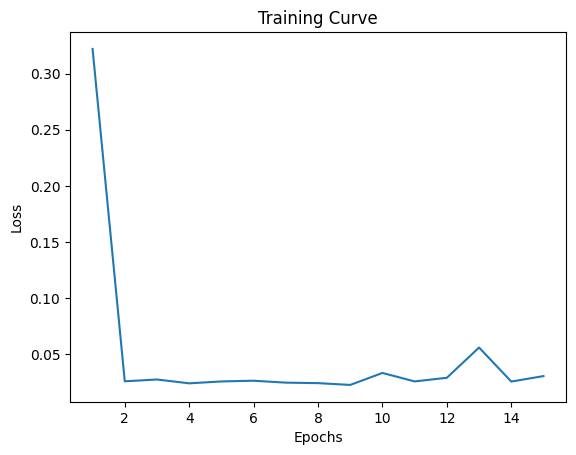

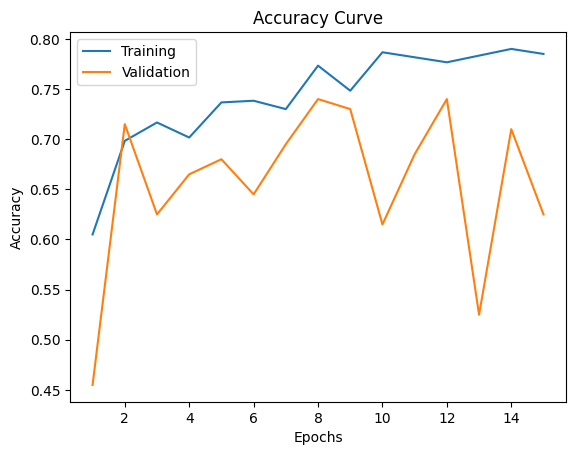

In [ ]:
resnet18 = ResNet18(3, ResBlock, num_classes = 4)
resnet18.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))

train_net(resnet18,train_loader, validation_loader,
          batch_size = 32, lr = 0.001, num_epochs = 15)